In [1]:
# import stlab
import numpy as np
import pickle
import multiprocessing as mp
import matplotlib.pyplot as plt
from copy import copy

In [2]:
from numpy import tan, pi, sqrt
from numpy.fft import fft, ifft
from scipy.optimize import minimize, curve_fit
from scipy.constants import e,h,hbar,k,G,epsilon_0
from lmfit import Model, Parameters
phi_0 = hbar/2./e
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import signal
import matplotlib as mpl

In [3]:
from qutip import *
qutip.settings.has_mkl=False

# Fitting curve

In [4]:
# For BS interaction.

def spectroscopy_bs(wp_list, g, A, B, gamma, detun):

    #Independent variable
    """
    wp_list : Probe frequency.
    g       : Sideband transition rate.
    A       : Scaling fitting factor.
    B       : Offset fitting factor.
    gamma   : Decay rate of the transmon
    detun   : delta_omega_{mat}. See supplementary Table 1. 
    """
    
    # Fixed variables
    
    # Cavity (b)
    wc = 4.0755e9
    kappa = 10.2e6
    Nc  = 5        ## Dimension of Hilbert space.
    chi = 497e+3
    
    # Qubit (a)
    wq = wc + detun ## Rotating frame. To eleminate the time-dependence of probe Hamiltonian.
    Aq = 150e6*1
    gamma_phi = 0e3 ##inhomogenous linewidth.
    Nq  = 4         ## Dimension of Hilbert space.
    eps = 65.3e3    ##Half of probe amplitude (653e3 for BS_7dBm.data).
    
    g = 2*pi*g
    chi = 2*pi*chi
    wq  = 2*pi*wq
    wc  = 2*pi*wc
    gamma = 2*pi*gamma
    gamma_phi = 2*pi*gamma_phi
    Aq = 2*pi*Aq
    kappa = 2*pi*kappa
    wp_list = wp_list*2*pi
    eps = 2*pi*eps
    
    # Hamiltonian
    a = tensor(destroy(Nq), qeye(Nc))
    b = tensor(qeye(Nq), destroy(Nc))
    num_b = b.dag()*b
    num_a = a.dag()*a
    r=[]
    H0 = wq*num_a + wc*num_b - 0.5*Aq*a.dag()*a.dag()*a*a - g*(a.dag()*b + b.dag()*a)
    #    qubit      cavity     anharmonicity                sideband coupling
    
    # Calculate spectrum
    for wp in wp_list:
        H = H0 - (wq-wc-wp-detun)*num_a - wp*num_b + eps*1j*(b.dag()-b) - 2*chi*num_a*num_b
        c_ops = [np.sqrt(gamma)*a, np.sqrt(gamma_phi)*num_a, np.sqrt(kappa)*b]  
        rho_ss = steadystate(H, c_ops)  ## steady-state since interested in f-domain
        r.append(np.absolute([expect(b,rho_ss)])**2)
    
    out = A*np.array(r) + B
    return np.concatenate(out)

In [21]:
# For TMS interaction.

def spectroscopy_tms(wp_list, g, A, B,  gamma ,detun):
    
    """
    wp_list : Probe frequency.
    g       : Sideband transition rate.
    A       : Scaling fitting factor.
    B       : Offset fitting factor.
    gamma   : Decay rate of the transmon
    detun   : delta_omega_{mat}. See supplementary Table 1. 
    """
    
    # Fixed variables
    
    # Cavity (b)
    wc = 4.0755e9
    kappa = 10.2e6
    Nc     = 5      ## Dimension of Hilbert space.
    chi = 497e+3
    
    # Qubit (a)
    wq = 6.8112e9  
    Aq = 150e6
    gamma_phi = 0e3  ##inhomogenous linewidth
    Nq  = 4          ## Dimension of Hilbert space.
    eps = 653e3      ##Half of probe amplitude.
    
    g = 2*pi*g
    chi = 2*pi*chi
    wq  = 2*pi*wq
    wc  = 2*pi*wc
    gamma = 2*pi*gamma
    gamma_phi = 2*pi*gamma_phi
    Aq = 2*pi*Aq
    kappa = 2*pi*kappa
    wp_list = wp_list*2*pi
    eps = 2*pi*eps
    detun = 2*pi*detun
    
    # Hamiltonian
    a = tensor(destroy(Nq), qeye(Nc))
    b = tensor(qeye(Nq), destroy(Nc))
    num_b = b.dag()*b
    num_a = a.dag()*a
    r=[]
    H0 = wq*num_a + wc*num_b - 0.5*Aq*a.dag()*a.dag()*a*a - g*(a.dag()*b.dag() + b*a)
    #    qubit      cavity     anharmonicity                   sideband coupling
    
    # Calculate spectrum
    for wp in wp_list:
        H = H0 - (wc+wq-wp-detun)*num_a - wp*num_b + eps*1j*(b.dag()-b) - 2*chi*num_a*num_b
        c_ops = [np.sqrt(gamma)*a, np.sqrt(gamma_phi)*num_a, np.sqrt(kappa)*b]  
        rho_ss = steadystate(H, c_ops)  ## steady-state since interested in f-domain
        r.append([np.absolute(expect(b,rho_ss))**2])
    
    out = A*np.array(r) + B
    return np.concatenate(out)

# Load raw data and fitting curves.

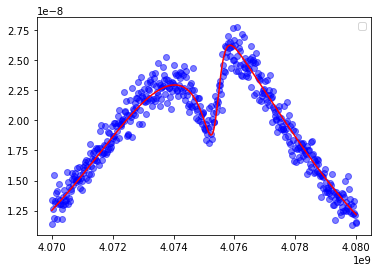

[[Model]]
    Model(spectroscopy_bsb)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 501
    # variables        = 5
    chi-square         = 4.5121e-16
    reduced chi-square = 9.0970e-19
    Akaike info crit   = -20807.1527
    Bayesian info crit = -20786.0697
[[Variables]]
    g:      1018353.56 +/- 21868.5162 (2.15%) (init = 1072122)
    A:      1.6511e-04 +/- 1.9206e-06 (1.16%) (init = 0.0002015)
    B:     -1.5484e-09 +/- 2.4366e-10 (15.74%) (init = -4.9703e-09)
    gamma:  283794.186 +/- 14169.0765 (4.99%) (init = 261494.4)
    detun:  110648.906 +/- 13281.5249 (12.00%) (init = 300000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, B)         = -0.983
    C(g, gamma)     =  0.953
    C(gamma, detun) = -0.289
    C(g, A)         =  0.170
    C(g, B)         = -0.143
    C(g, detun)     = -0.139


In [25]:
## load fitting results

load_file = open('TMS_-12dBm.dat', 'rb')
loaddata = pickle.load(load_file)

plt.figure()
plt.plot(loaddata['probe_freq'], loaddata['transmission_data'], 'bo', alpha=0.5)
plt.plot(loaddata['probe_freq'], loaddata['transmission_fit'], 'r-', alpha=1)
plt.legend()
plt.show()

print(loaddata['fitting_result'])

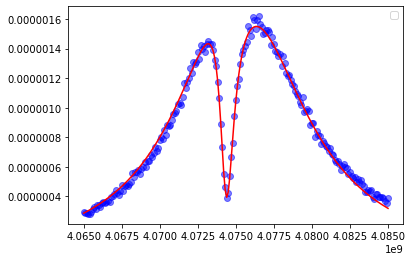

[[Model]]
    Model(spectroscopy_rsb)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 201
    # variables        = 5
    chi-square         = 1.7356e-13
    reduced chi-square = 8.8552e-16
    Akaike info crit   = -6961.79559
    Bayesian info crit = -6945.27906
[[Variables]]
    g:      1207239.40 +/- 8963.35276 (0.74%) (init = 1000000)
    A:      1.0120e-04 +/- 6.3353e-07 (0.63%) (init = 0.00015)
    B:     -4.8844e-08 +/- 5.6366e-09 (11.54%) (init = -2.2716e-10)
    gamma:  436638.252 +/- 21236.8603 (4.86%) (init = 333922.4)
    detun: -910644.534 +/- 6494.18732 (0.71%) (init = -500000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, B)         = -0.920
    C(A, gamma)     =  0.548
    C(B, gamma)     = -0.407
    C(g, gamma)     = -0.231
    C(gamma, detun) =  0.203
    C(A, detun)     =  0.120
    C(g, B)         =  0.111
    C(g, A)         = -0.105


In [9]:
## load fitting results

load_file = open('BS_7dBm.dat', 'rb')
loaddata = pickle.load(load_file)

plt.figure()
plt.plot(loaddata['probe_freq'], loaddata['transmission_data'], 'bo', alpha=0.5)
plt.plot(loaddata['probe_freq'], loaddata['transmission_fit'], 'r-', alpha=1)
plt.legend()
plt.show()

print(loaddata['fitting_result'])

# Summarized data

In [10]:
meas_wsb_bs = [0.314533,0.447233,0.537738,0.698482,0.860576,1.120816,1.406590,2.001017,2.414479]
meas_wsb_tms = [2.3413,2.42841,2.68145,2.76154,2.85475,3.12612,3.25364,
                  3.48857,3.68754,4.12177,5.15856,6.22631]

# Sideband transition rates extracted from the fitting. Unit : MHz.

meas_fshifts_bs = 2*[-0.003303,-0.004218,-0.005544,-0.006540,-0.008385,-0.010231,-0.013298,-0.016597,-0.022895]
meas_fshifts_tms = 2*[-0.02383,-0.02432,-0.02612,-0.02665,-0.02762,-0.03072,-0.03179,-0.0329,-0.0357,-0.03924,-0.05225,-0.05957]

# Frequency shifts (delta_ometa_t) extracted from the fitting. Unit : MHz.